In [2]:
import numpy as np
import torch
import pandas as pd
from collections import deque
!pip install ucimlrepo  --quiet

In [53]:
from ucimlrepo import fetch_ucirepo

# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets
# metadata 
metadata = predict_students_dropout_and_academic_success.metadata

# variable information 
variable_info = predict_students_dropout_and_academic_success.variables

df = X
df['Target'] = y

print(f"{df.shape[0]} entries with {df.shape[1]} features")

4424 entries with 37 features


In [54]:
categorical_vars = {
    'Marital Status',
    'Application mode',
    'Course',
    'Daytime/evening attendance',
    'Previous qualification',
    'Nacionality',
    'Mother\'s qualification',
    'Father\'s qualification',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder',
    'International',
    'Target'
}
quantitative_vars = {
   'Application order',
    'Previous qualification (grade)',
    'Admission grade',
    'Age at enrollment',
   'Curricular units 1st sem (enrolled)',
   'Curricular units 1st sem (credited)',
   'Curricular units 1st sem (evaluations)',
   'Curricular units 1st sem (approved)',
   'Curricular units 1st sem (grade)',
   'Curricular units 1st sem (without evaluations)',
   'Curricular units 2nd sem (credited)',
   'Curricular units 2nd sem (enrolled)',
   'Curricular units 2nd sem (evaluations)',
   'Curricular units 2nd sem (approved)',
   'Curricular units 2nd sem (grade)',
   'Curricular units 2nd sem (without evaluations)',
   'Unemployment rate',
   'Inflation rate',
    'GDP'
}
print("categorical vars", len(categorical_vars))
print("quantitative vars", len(quantitative_vars))


categorical vars 18
quantitative vars 19


In [55]:
drop_features = set(["Father's qualification",
 'Gender',
 'Previous qualification (grade)',
 'International',
 'Curricular units 2nd sem (without evaluations)',
 'Marital Status',
 'GDP',
 'Displaced',
 'Debtor',
 'Inflation rate',
 "Mother's occupation",
 "Father's occupation",
 'Unemployment rate',
 'Previous qualification',
 'Curricular units 1st sem (without evaluations)',
 "Mother's qualification",
 'Curricular units 2nd sem (enrolled)',
 'Application order',
 'Age at enrollment',
 'Educational special needs','Nacionality'])

second_drop = set(['Curricular units 1st sem (grade)', 'Curricular units 1st sem (evaluations)'])

drop_features = drop_features.union(second_drop)

quantitative_vars -= drop_features
categorical_vars -= drop_features
df.drop(drop_features, axis=1, inplace=True)

df_encoded = df[df['Target'].isin(['Graduate', 'Dropout'])].copy()
df_encoded["Target"] = df_encoded["Target"].replace({'Graduate': 0, 'Dropout': 1})
# Applying one-hot encoding on categorical variables
df_encoded = pd.get_dummies(df_encoded, columns=list(categorical_vars - {'Target'}))

# normalize quantitative columns:
df_encoded[list(quantitative_vars)] = df_encoded[list(quantitative_vars)].apply(lambda x: (x-x.min())/(x.max()-x.min()))

valid_count = int(len(df_encoded) * 0.7)
test_count = int(len(df_encoded) * 0.8)
df_shuffled = df_encoded.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_encoded[:valid_count].reset_index(drop=True)
df_valid = df_encoded[valid_count:test_count].reset_index(drop=True)
df_test = df_encoded[test_count:].reset_index(drop=True)


/var/folders/pv/x97pt2hs4r57jwqqpz0z10_40000gn/T/ipykernel_42132/963560128.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded["Target"] = df_encoded["Target"].replace({'Graduate': 0, 'Dropout': 1})


In [58]:
from torch.utils.data import Dataset, DataLoader
class DropoutDS(Dataset):
    def __init__(self, x,y):
        self.input_df = x
        self.output_df = y

    def __len__(self):
        return self.input_df.shape[0]

    def __getitem__(self, idx):
        inp = self.input_df.iloc[idx].astype(float)
        out = np.expand_dims(self.output_df.iloc[idx].astype(float), axis=0)
        # out = self.output_df.iloc[idx].astype(float)
        inp_t = torch.tensor(inp.values, dtype=torch.float32)
        out_t = torch.tensor(out, dtype=torch.float32)
        return inp_t, out_t



In [66]:
import torch.nn as nn
def get_mlp_model(dropout_prob):
    model = nn.Sequential(
        nn.Linear(49, 64),
        nn.ReLU(),
        nn.Dropout(p=dropout_prob),
        # nn.Linear(256, 128),
        # nn.ReLU(),
        # nn.Dropout(p=dropout_prob),
        # nn.Linear(128, 64),
        # nn.ReLU(),
        # nn.Dropout(p=dropout_prob),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=dropout_prob),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
        nn.Sigmoid()
    )

    def init_model_weights(model):
        if isinstance(model, nn.Linear):
            nn.init.normal_(model.weight, mean=0, std=0.1)
            nn.init.constant_(model.bias, 0)

    model.apply(init_model_weights)
    # print(f"{sum(p.numel() for p in model.parameters())} trainable params")
    return model

epoch: 99 | train_loss: 0.23 valid_loss: 0.32| train_acc: 0.9174 | valid_acc: 0.8703
Best Model Performance:
	train_acc: 0.9185
	valid_acc: 0.8973


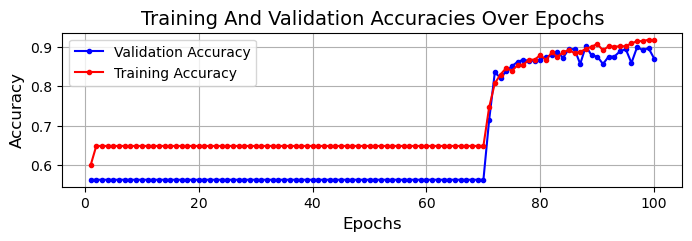

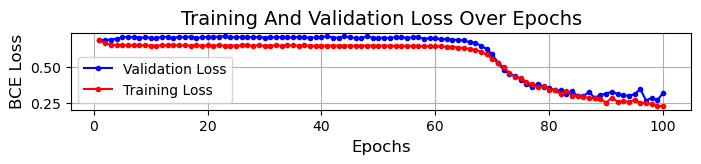

KeyboardInterrupt: 

In [64]:
import matplotlib.pyplot as plt

def get_mis_cls(outputs, tgt):
    cls = torch.round(outputs).type(torch.int32)
    tgt = tgt.type(torch.int32)
    mis_cls = torch.sum(torch.abs(cls - tgt))
    return mis_cls.item()
def plot_performance(epochs, all_valid_acc, all_train_acc, all_valid_loss, all_train_loss):
    epochs = np.arange(1, epochs + 1)
    # PLOT ACCURACIES
    plt.figure(figsize=(8,2))
    plt.plot(epochs, all_valid_acc, marker='.', color='b', label='Validation Accuracy')
    plt.plot(epochs, all_train_acc, marker='.', color='r', label='Training Accuracy')
    plt.title('Training And Validation Accuracies Over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)

    # Add grid and legend
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.show()

    plt.figure(figsize=(8,1))
    plt.plot(epochs, all_valid_loss, marker='.', color='b', label='Validation Loss')
    plt.plot(epochs, all_train_loss, marker='.', color='r', label='Training Loss')
    plt.title('Training And Validation Loss Over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('BCE Loss', fontsize=12)

    # Add grid and legend
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.show() 

def train_model(train_dl, valid_dl, id, dropout=0.25):
    model = get_mlp_model(dropout)
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.95)
    def valid_epoch(dl):
        model.train(False)
        running_loss = 0.
        total_mis_cls = 0
        with torch.no_grad():
            for i, data in enumerate(dl):
                inputs, tgt = data

                outputs = model(inputs)
                
                loss = loss_fn(outputs, tgt)
                running_loss += loss.item()
                total_mis_cls += get_mis_cls(outputs, tgt)
        return running_loss/len(dl), 1 - float(total_mis_cls) / (len(dl) * batch_size)

    def train_epoch():
        model.train(True)
        running_loss = 0.
        total_mis_cls = 0
        for i, data in enumerate(train_dl):
            inputs, tgt = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, tgt)
            total_mis_cls += get_mis_cls(outputs, tgt)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        return running_loss/len(train_dl), 1 - float(total_mis_cls) / x_train.shape[0]

    EPOCHS = 100
    all_train_acc = []
    all_valid_acc = []
    all_valid_loss = []
    all_train_loss = []
    acc_queue = deque()
    max_acc = -1e10
    best_performance = 0,0
    count_avg_perf = 5
    for epoch in range(EPOCHS):
        avg_train_loss, train_acc = train_epoch()
        avg_valid_loss, valid_acc = valid_epoch(valid_dl)
        all_train_loss.append(avg_train_loss)
        all_valid_loss.append(avg_valid_loss)
        all_train_acc.append(train_acc)
        all_valid_acc.append(valid_acc)
        if len(acc_queue) > count_avg_perf:
            acc_queue.popleft()
        acc_queue.append(valid_acc)
        curr_max_acc = sum(list(acc_queue)) / float(count_avg_perf)
        if curr_max_acc > max_acc:
            max_acc =  curr_max_acc
            best_performance = (train_acc, valid_acc, avg_train_loss, avg_valid_loss)
            torch.save(model, f'mlp_ensemble/mlp_model_{id}.pt')
        print(f'epoch: {epoch} | train_loss: {avg_train_loss:.2f} valid_loss: {avg_valid_loss:.2f}'
            f'| train_acc: {train_acc:.4f} | valid_acc: {valid_acc:.4f}', end= '\r')
    print(f'\nBest Model Performance:\n\ttrain_acc: {best_performance[0]:.4f}\n\tvalid_acc: {best_performance[1]:.4f}')
    # print(f'\nBest Model Performance:\n\ttrain_loss: {best_performance[2]:.4f}\n\tvalid_loss: {best_performance[3]:.4f}')
    plot_performance(EPOCHS,all_valid_acc, all_train_acc, all_valid_loss, all_train_loss)
    return best_performance[1] 


# SAMPLE HERE

# print(f"train_ds: {df_train.shape[0]} samples")
# print(f"test_ds: {df_test.shape[0]} samples")
# print(f'[train_ds]: input shape: {x_train.shape}, output shape: {y_train.shape}')
# print(f'[valid_ds]: input shape: {x_valid.shape}, valid shape: {y_valid.shape}')
# print(f'[test_ds]: input shape: {x_test.shape}, output shape: {y_test.shape}')




batch_size = 10
dp_in_sample = int(df_train.shape[0] /3)
for i in range(3):
    #i_train_df = df_train.sample(n=df_train.shape[0], replace=True)
    #i_valid_df = df_valid.sample(n=df_valid.shape[0], replace=True)
    # partition dataset

    i_train_df = df_train[i * dp_in_sample:(i + 1)* dp_in_sample]
    i_valid_df = df_valid
    
    y_train = i_train_df["Target"]
    x_train = i_train_df.drop(["Target"], axis=1)

    y_valid = i_valid_df["Target"]
    x_valid = i_valid_df.drop(["Target"], axis=1)

    train_dl = DataLoader(DropoutDS(x_train, y_train), batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(DropoutDS(x_valid, y_valid), batch_size=batch_size, shuffle=True)
    train_model(train_dl, valid_dl, i)
    
    


In [65]:
# evaluating on test dataset:
y_test = df_test["Target"]
x_test = df_test.drop(["Target"], axis=1)
test_dl = DataLoader(DropoutDS(x_test, y_test), batch_size=batch_size, shuffle=True) 
models = [torch.load(f'mlp_ensemble/mlp_model_{id}.pt') for id in range(10)]
for m in models:
    m.train(False)
total_mis_cls = 0
with torch.no_grad():
    for i, data in enumerate(test_dl):
        inputs, tgt = data
        outputs = torch.stack([m(inputs).squeeze() for m in models], dim=0)
        ensemble_pred = torch.mode(outputs.round(),0).values
        total_mis_cls +=torch.sum(torch.abs(ensemble_pred - tgt.squeeze())).item()
acc = 1 - float(total_mis_cls) / (len(test_dl) * batch_size)
print(f"Ensemble Accuracy: {acc:.4f}")

/var/folders/pv/x97pt2hs4r57jwqqpz0z10_40000gn/T/ipykernel_42132/2273936778.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models = [torch.load(f'mlp_ensemble/mlp_model

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x49 and 246x256)

## 10 Fold Cross Validation

/Users/alexiy/miniforge3/envs/torch_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


epoch: 99 | train_loss: 0.20 valid_loss: 0.22| train_acc: 0.9274 | valid_acc: 0.9077
Best Model Performance:
	train_acc: 0.9178
	valid_acc: 0.9038


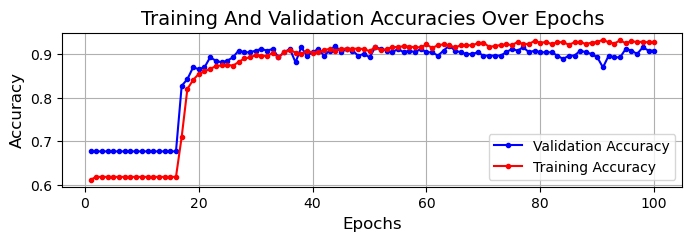

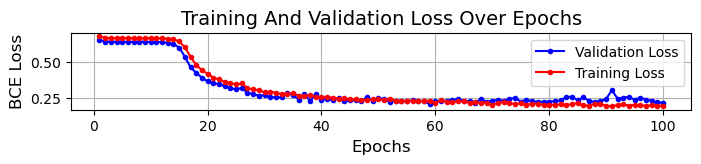

epoch: 99 | train_loss: 0.18 valid_loss: 0.25| train_acc: 0.9335 | valid_acc: 0.9346
Best Model Performance:
	train_acc: 0.9257
	valid_acc: 0.9269


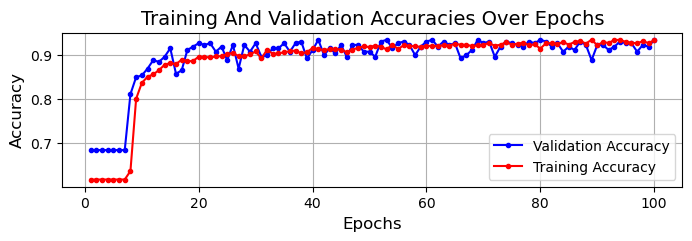

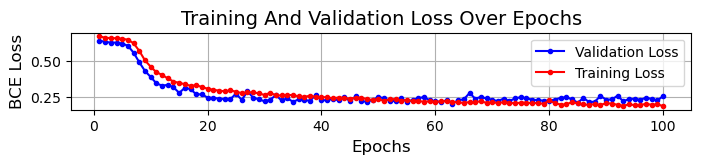

epoch: 99 | train_loss: 0.19 valid_loss: 0.24| train_acc: 0.9331 | valid_acc: 0.9192
Best Model Performance:
	train_acc: 0.9226
	valid_acc: 0.9192


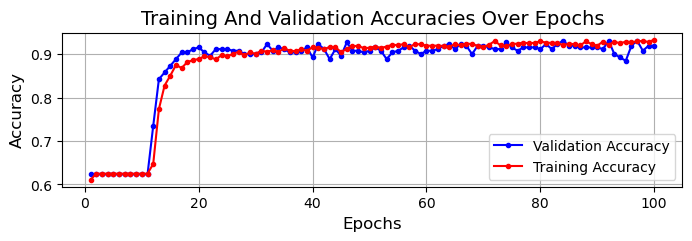

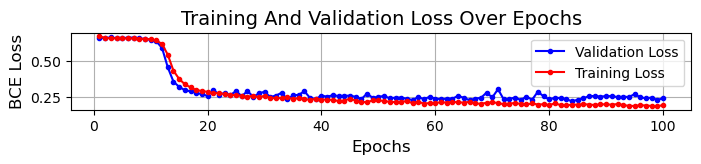

epoch: 99 | train_loss: 0.19 valid_loss: 0.25| train_acc: 0.9257 | valid_acc: 0.9192
Best Model Performance:
	train_acc: 0.9252
	valid_acc: 0.9154


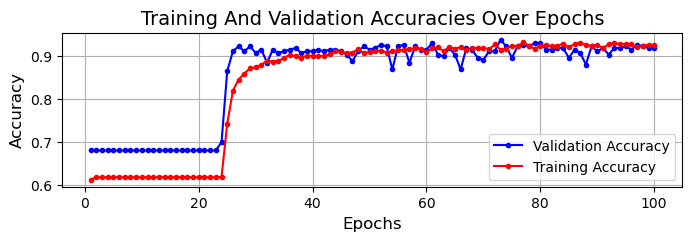

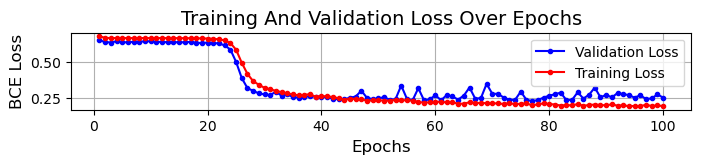

epoch: 99 | train_loss: 0.19 valid_loss: 0.19| train_acc: 0.9287 | valid_acc: 0.9231
Best Model Performance:
	train_acc: 0.9160
	valid_acc: 0.9385


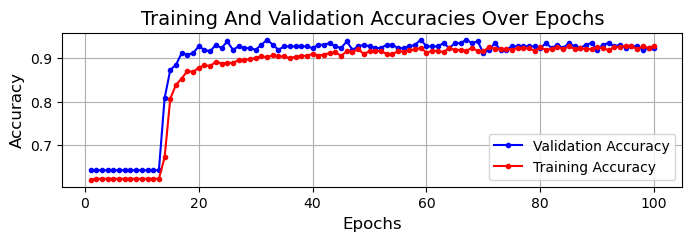

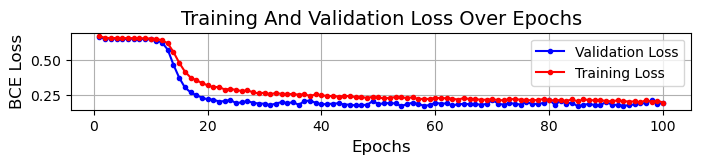

epoch: 99 | train_loss: 0.19 valid_loss: 0.31| train_acc: 0.9314 | valid_acc: 0.8962
Best Model Performance:
	train_acc: 0.9335
	valid_acc: 0.9038


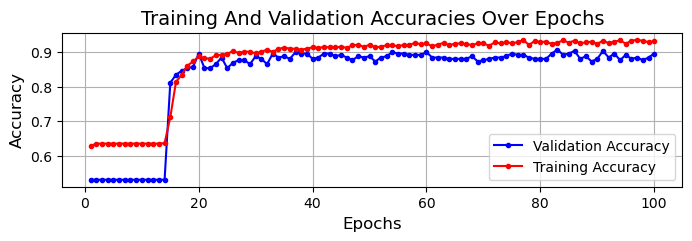

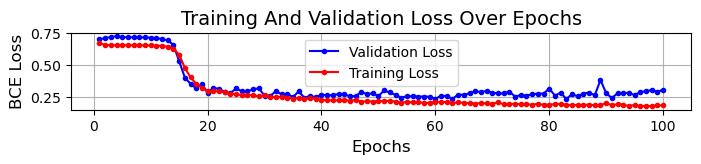

epoch: 99 | train_loss: 0.20 valid_loss: 0.22| train_acc: 0.9230 | valid_acc: 0.9423
Best Model Performance:
	train_acc: 0.9007
	valid_acc: 0.9462


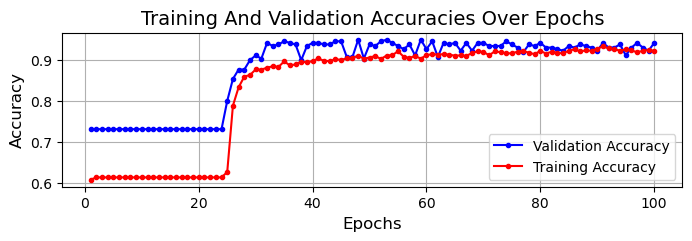

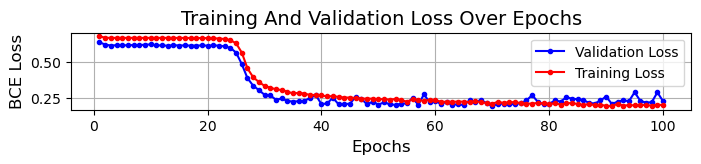

epoch: 99 | train_loss: 0.19 valid_loss: 0.33| train_acc: 0.9279 | valid_acc: 0.8962
Best Model Performance:
	train_acc: 0.9283
	valid_acc: 0.9000


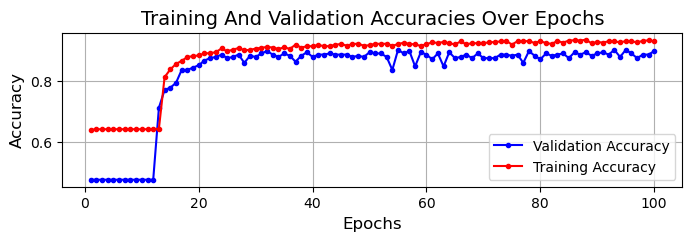

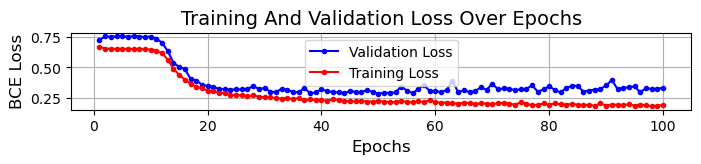

epoch: 99 | train_loss: 0.19 valid_loss: 0.25| train_acc: 0.9322 | valid_acc: 0.8962
Best Model Performance:
	train_acc: 0.9174
	valid_acc: 0.9192


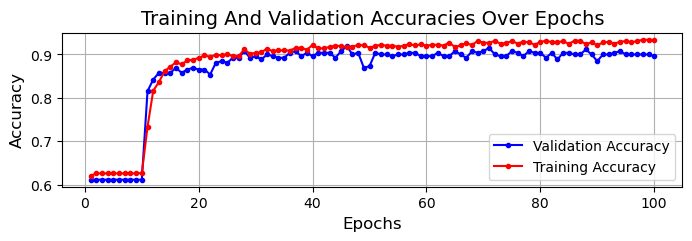

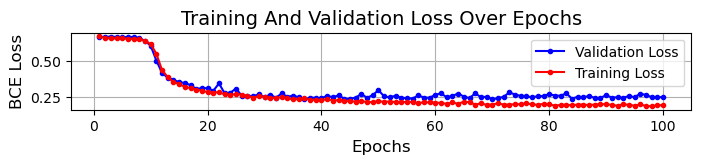

epoch: 99 | train_loss: 0.19 valid_loss: 0.38| train_acc: 0.9283 | valid_acc: 0.8731
Best Model Performance:
	train_acc: 0.9252
	valid_acc: 0.8923


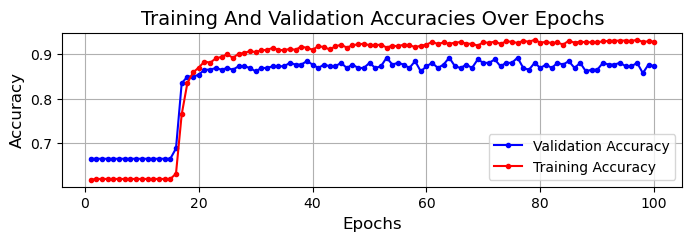

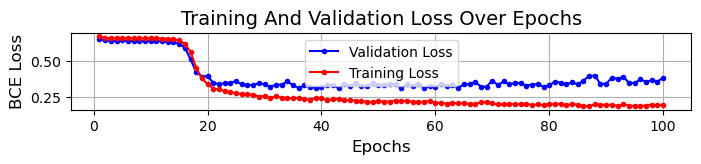

epoch: 99 | train_loss: 0.20 valid_loss: 0.24| train_acc: 0.9230 | valid_acc: 0.9154
Best Model Performance:
	train_acc: 0.9217
	valid_acc: 0.9154


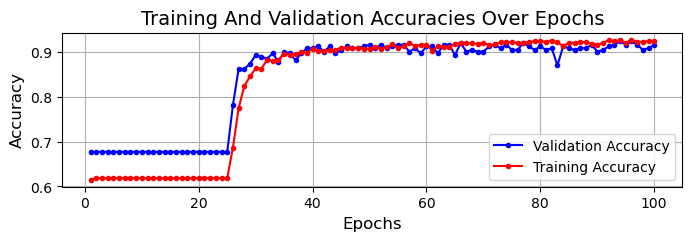

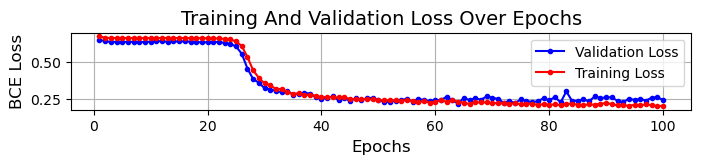

epoch: 99 | train_loss: 0.21 valid_loss: 0.22| train_acc: 0.9252 | valid_acc: 0.9077
Best Model Performance:
	train_acc: 0.9257
	valid_acc: 0.9231


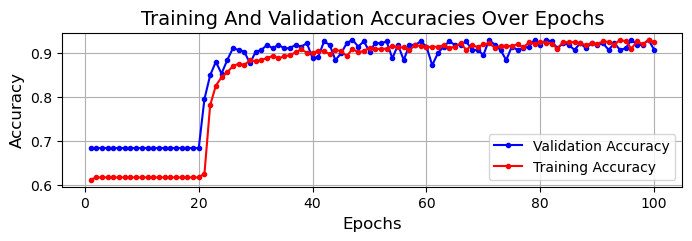

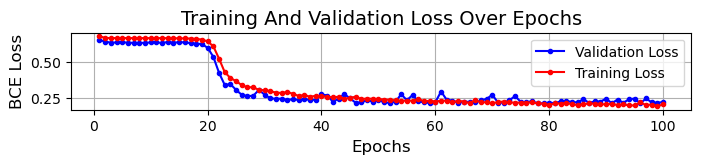

epoch: 99 | train_loss: 0.20 valid_loss: 0.26| train_acc: 0.9252 | valid_acc: 0.9077
Best Model Performance:
	train_acc: 0.9174
	valid_acc: 0.9231


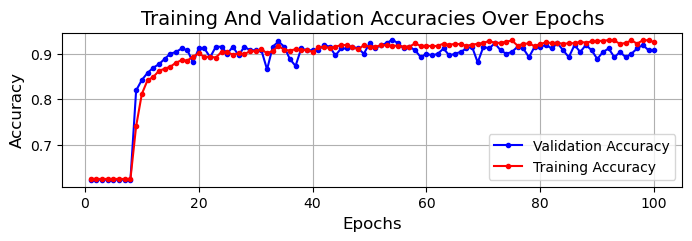

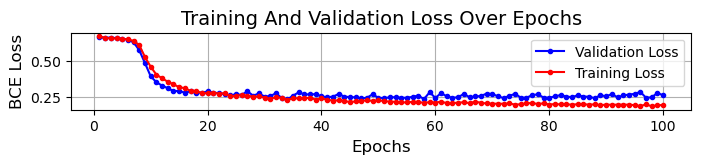

epoch: 99 | train_loss: 0.19 valid_loss: 0.27| train_acc: 0.9244 | valid_acc: 0.9154
Best Model Performance:
	train_acc: 0.9165
	valid_acc: 0.9115


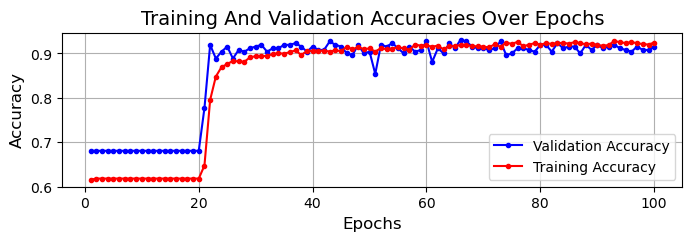

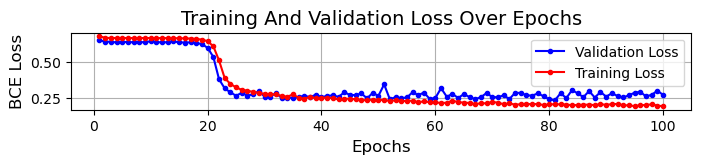

epoch: 99 | train_loss: 0.20 valid_loss: 0.18| train_acc: 0.9292 | valid_acc: 0.9231
Best Model Performance:
	train_acc: 0.9222
	valid_acc: 0.9385


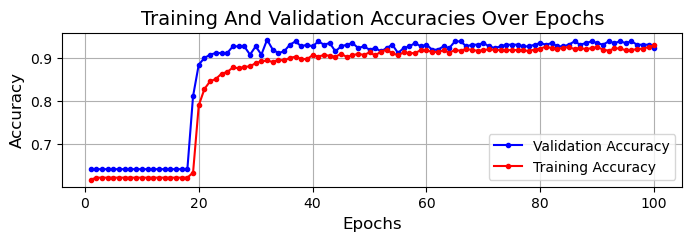

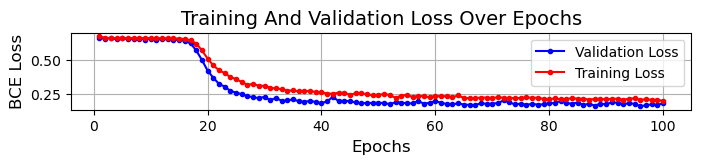

epoch: 99 | train_loss: 0.19 valid_loss: 0.26| train_acc: 0.9296 | valid_acc: 0.8923
Best Model Performance:
	train_acc: 0.9239
	valid_acc: 0.9038


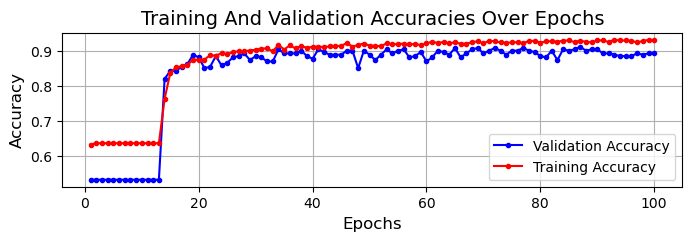

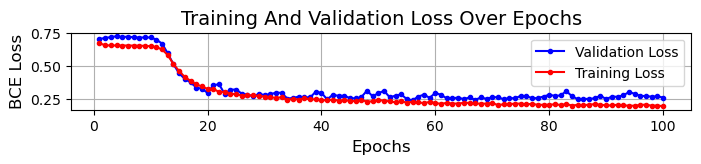

epoch: 99 | train_loss: 0.20 valid_loss: 0.23| train_acc: 0.9252 | valid_acc: 0.9385
Best Model Performance:
	train_acc: 0.9174
	valid_acc: 0.9423


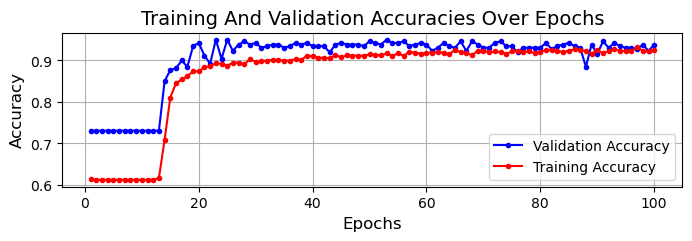

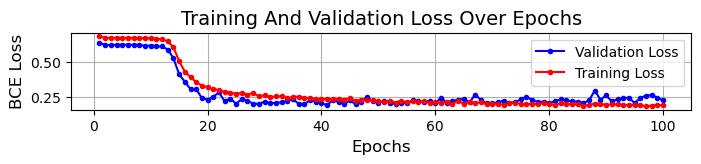

epoch: 99 | train_loss: 0.19 valid_loss: 0.34| train_acc: 0.9235 | valid_acc: 0.8885
Best Model Performance:
	train_acc: 0.9261
	valid_acc: 0.9000


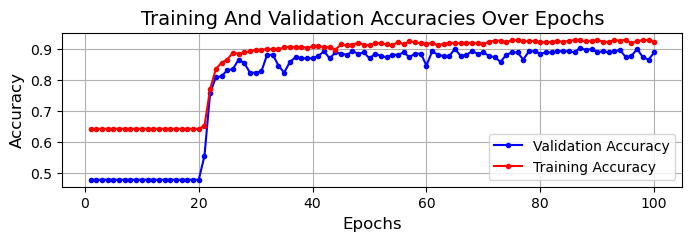

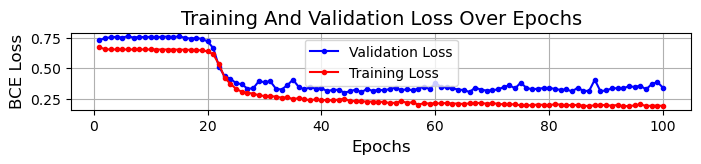

epoch: 99 | train_loss: 0.20 valid_loss: 0.25| train_acc: 0.9265 | valid_acc: 0.9000
Best Model Performance:
	train_acc: 0.9244
	valid_acc: 0.9154


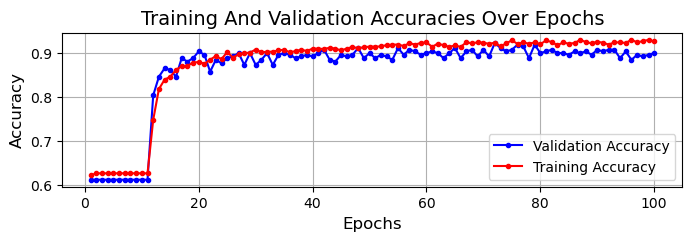

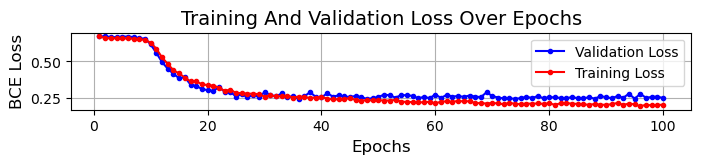

epoch: 99 | train_loss: 0.18 valid_loss: 0.35| train_acc: 0.9335 | valid_acc: 0.8808
Best Model Performance:
	train_acc: 0.9292
	valid_acc: 0.9000


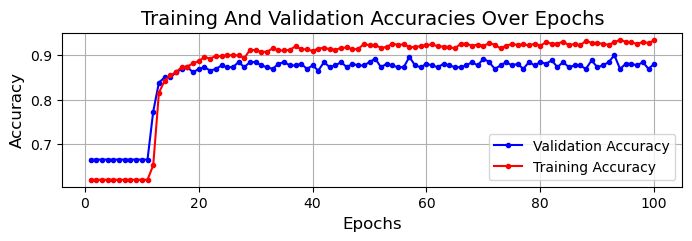

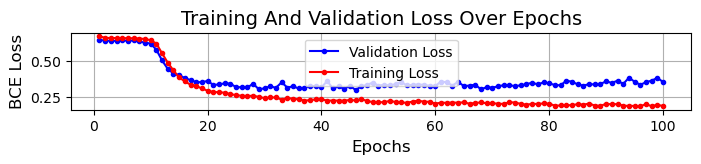

epoch: 99 | train_loss: 0.21 valid_loss: 0.21| train_acc: 0.9230 | valid_acc: 0.9231
Best Model Performance:
	train_acc: 0.9099
	valid_acc: 0.9115


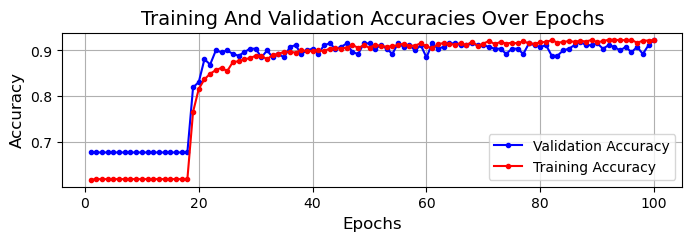

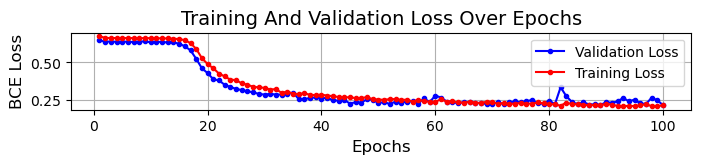

epoch: 99 | train_loss: 0.21 valid_loss: 0.21| train_acc: 0.9239 | valid_acc: 0.9231
Best Model Performance:
	train_acc: 0.9235
	valid_acc: 0.9269


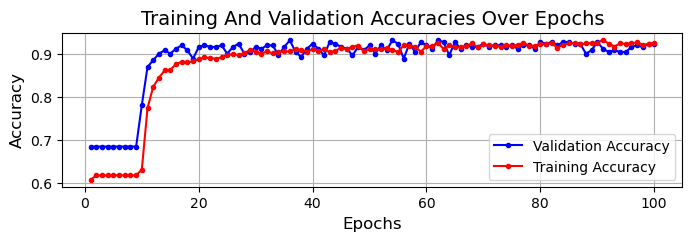

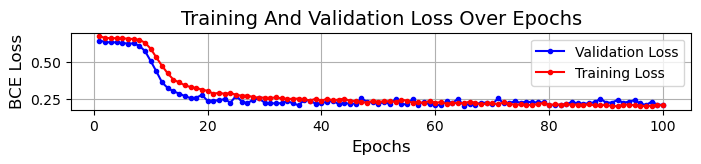

epoch: 99 | train_loss: 0.20 valid_loss: 0.25| train_acc: 0.9270 | valid_acc: 0.9231
Best Model Performance:
	train_acc: 0.9182
	valid_acc: 0.9154


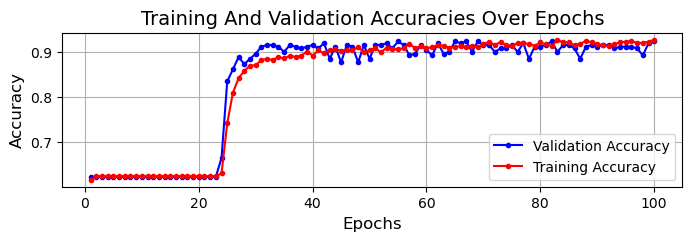

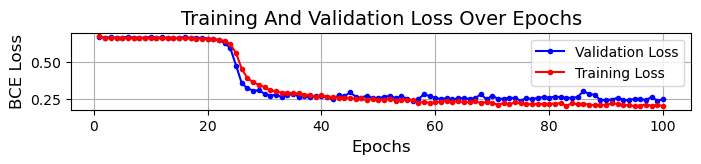

epoch: 99 | train_loss: 0.21 valid_loss: 0.30| train_acc: 0.9191 | valid_acc: 0.9077
Best Model Performance:
	train_acc: 0.9073
	valid_acc: 0.9269


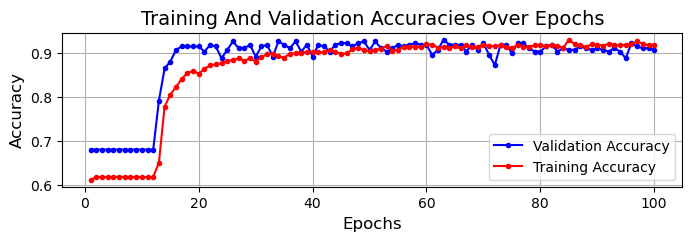

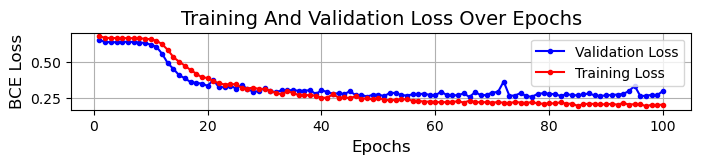

epoch: 99 | train_loss: 0.22 valid_loss: 0.19| train_acc: 0.9239 | valid_acc: 0.9154
Best Model Performance:
	train_acc: 0.9095
	valid_acc: 0.9308


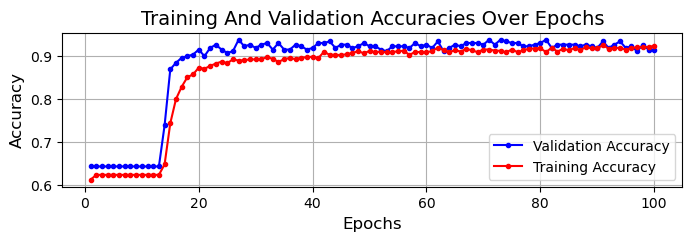

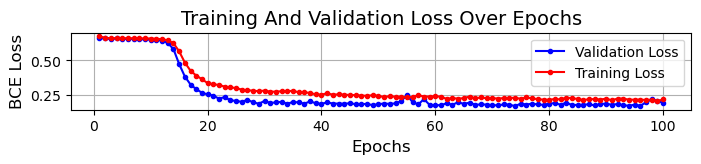

epoch: 99 | train_loss: 0.21 valid_loss: 0.27| train_acc: 0.9195 | valid_acc: 0.9000
Best Model Performance:
	train_acc: 0.9200
	valid_acc: 0.9000


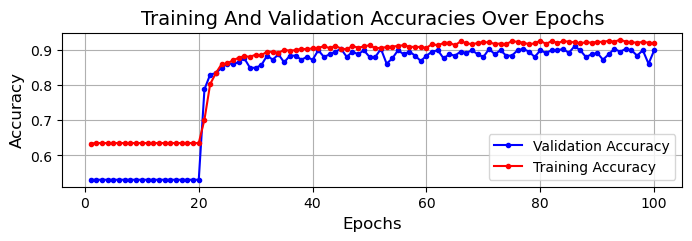

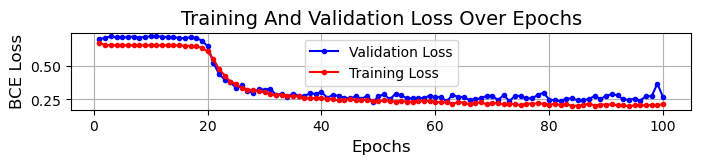

epoch: 99 | train_loss: 0.20 valid_loss: 0.23| train_acc: 0.9222 | valid_acc: 0.9308
Best Model Performance:
	train_acc: 0.9060
	valid_acc: 0.9423


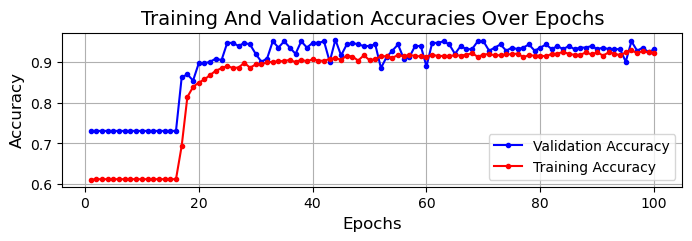

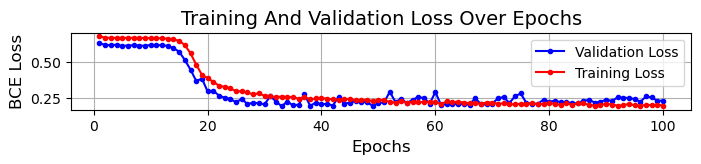

epoch: 99 | train_loss: 0.19 valid_loss: 0.32| train_acc: 0.9314 | valid_acc: 0.9000
Best Model Performance:
	train_acc: 0.9195
	valid_acc: 0.9000


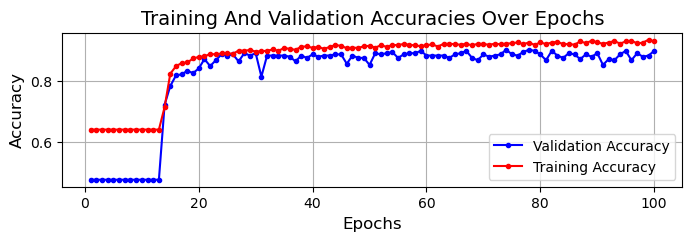

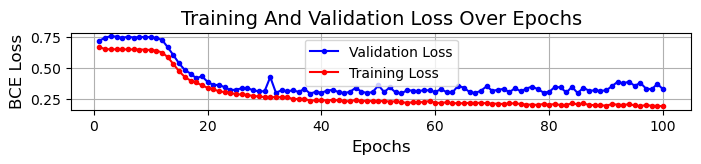

epoch: 99 | train_loss: 0.20 valid_loss: 0.28| train_acc: 0.9265 | valid_acc: 0.9154
Best Model Performance:
	train_acc: 0.9099
	valid_acc: 0.9115


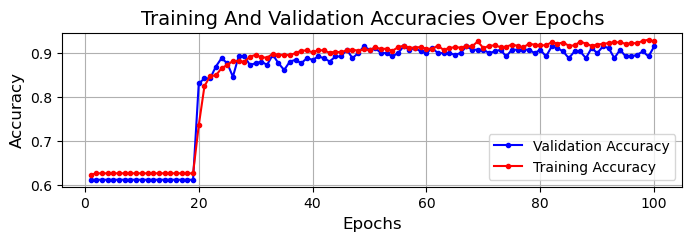

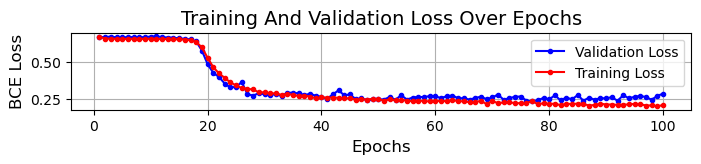

epoch: 99 | train_loss: 0.20 valid_loss: 0.37| train_acc: 0.9257 | valid_acc: 0.8731
Best Model Performance:
	train_acc: 0.9239
	valid_acc: 0.8769


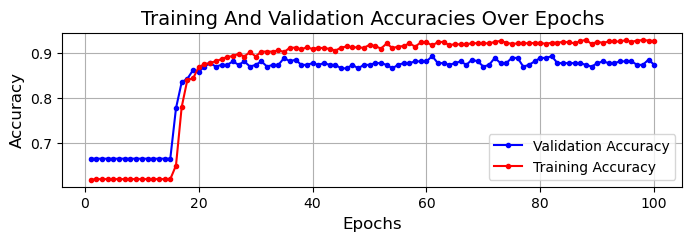

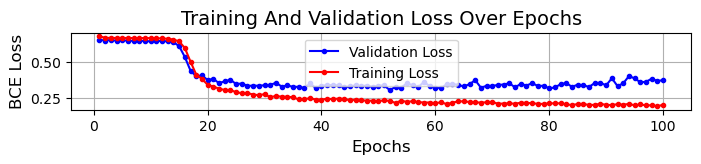

epoch: 99 | train_loss: 0.21 valid_loss: 0.21| train_acc: 0.9248 | valid_acc: 0.9038
Best Model Performance:
	train_acc: 0.9134
	valid_acc: 0.9077


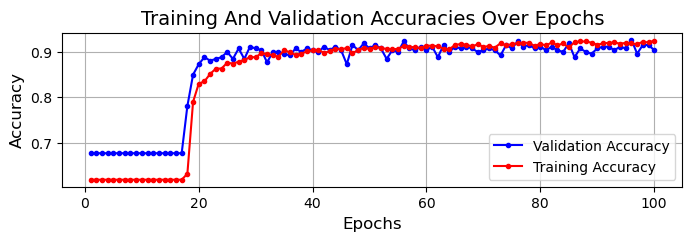

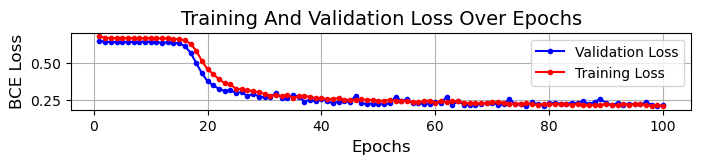

epoch: 99 | train_loss: 0.21 valid_loss: 0.22| train_acc: 0.9200 | valid_acc: 0.9192
Best Model Performance:
	train_acc: 0.9099
	valid_acc: 0.9269


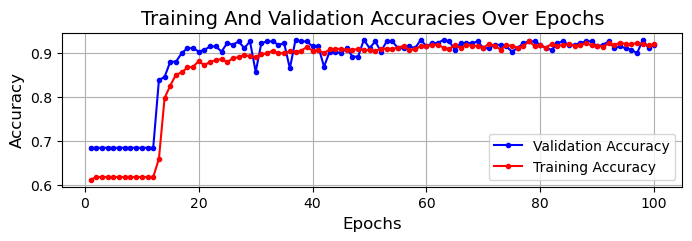

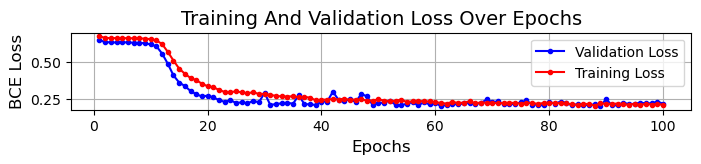

epoch: 99 | train_loss: 0.20 valid_loss: 0.27| train_acc: 0.9279 | valid_acc: 0.8923
Best Model Performance:
	train_acc: 0.9204
	valid_acc: 0.9192


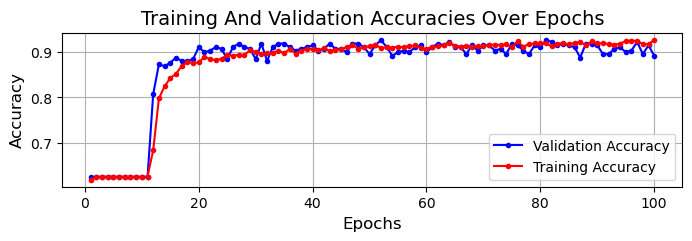

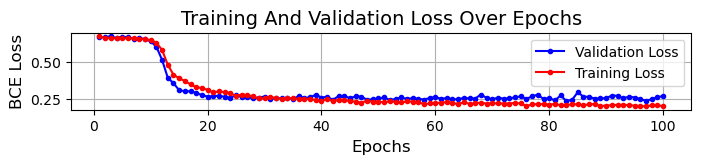

epoch: 99 | train_loss: 0.21 valid_loss: 0.28| train_acc: 0.9182 | valid_acc: 0.9038
Best Model Performance:
	train_acc: 0.9029
	valid_acc: 0.9192


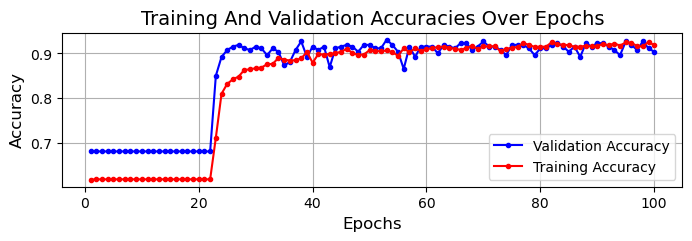

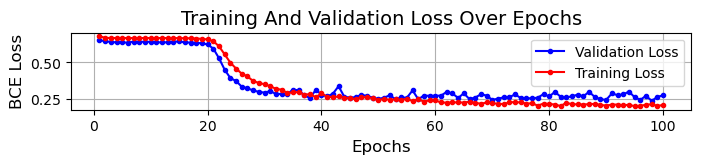

epoch: 99 | train_loss: 0.22 valid_loss: 0.18| train_acc: 0.9239 | valid_acc: 0.9308
Best Model Performance:
	train_acc: 0.9108
	valid_acc: 0.9385


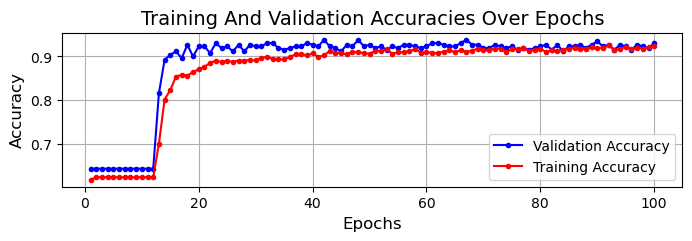

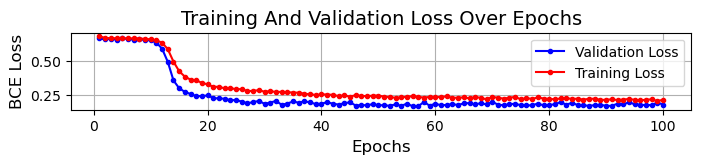

epoch: 99 | train_loss: 0.20 valid_loss: 0.25| train_acc: 0.9191 | valid_acc: 0.8923
Best Model Performance:
	train_acc: 0.9130
	valid_acc: 0.8923


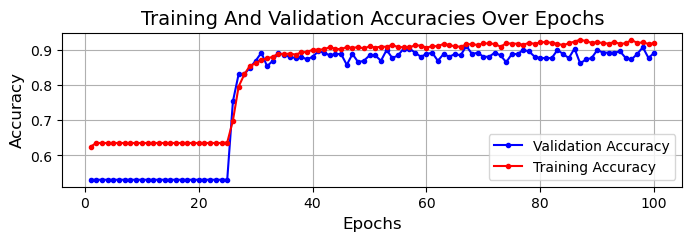

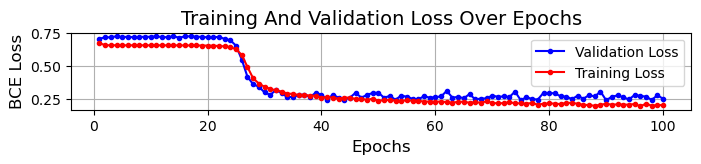

epoch: 99 | train_loss: 0.21 valid_loss: 0.23| train_acc: 0.9200 | valid_acc: 0.9346
Best Model Performance:
	train_acc: 0.8937
	valid_acc: 0.9462


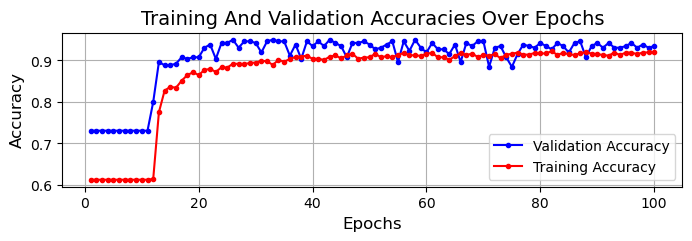

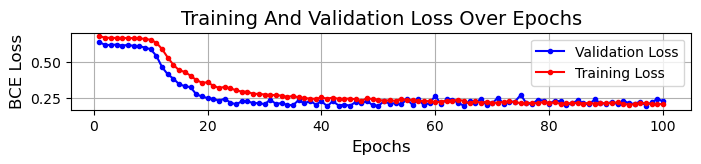

epoch: 99 | train_loss: 0.20 valid_loss: 0.32| train_acc: 0.9252 | valid_acc: 0.8846
Best Model Performance:
	train_acc: 0.9261
	valid_acc: 0.8885


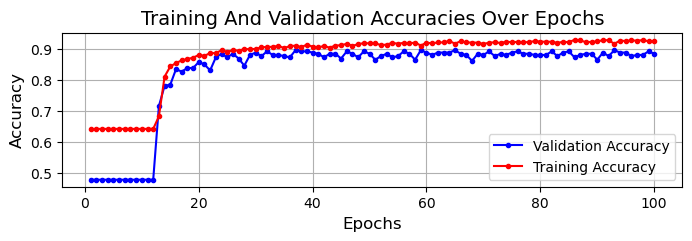

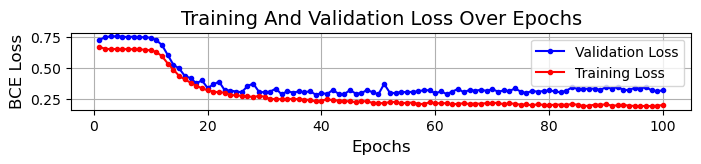

epoch: 99 | train_loss: 0.21 valid_loss: 0.26| train_acc: 0.9248 | valid_acc: 0.9000
Best Model Performance:
	train_acc: 0.9117
	valid_acc: 0.9115


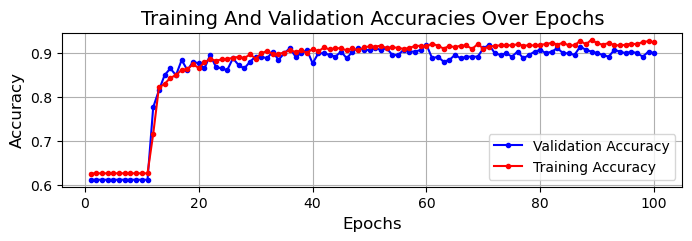

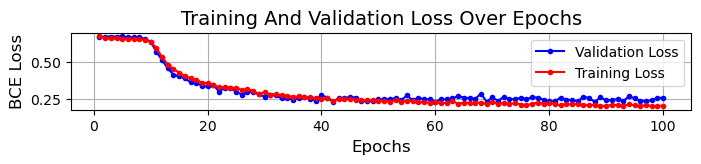

epoch: 99 | train_loss: 0.22 valid_loss: 0.36| train_acc: 0.9195 | valid_acc: 0.8577
Best Model Performance:
	train_acc: 0.9235
	valid_acc: 0.8808


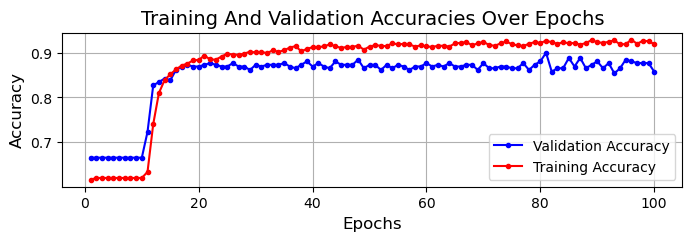

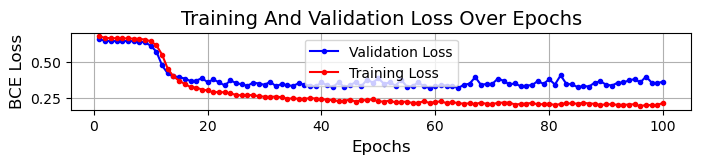

In [67]:
batch_size = 10
dp_in_sample = int(df_train.shape[0] /10)

n_partitions = 10
partitions = np.array_split(df_train, n_partitions)
num_features = None
for drop_out in [.2, .25, .3, .35]:
    all_acc = []
    for i in range(10):
        #i_train_df = df_train.sample(n=df_train.shape[0], replace=True)
        #i_valid_df = df_valid.sample(n=df_valid.shape[0], replace=True)
        # partition dataset
        i_train_df = pd.concat([partitions[j] for j in range(len(partitions)) if j != i],axis=0)
        i_valid_df = partitions[i]

        y_train = i_train_df["Target"]
        x_train = i_train_df.drop(["Target"], axis=1)
        num_featurs = x_train.shape[0]

        y_valid = i_valid_df["Target"]
        x_valid = i_valid_df.drop(["Target"], axis=1)

        train_dl = DataLoader(DropoutDS(x_train, y_train), batch_size=batch_size, shuffle=True)
        valid_dl = DataLoader(DropoutDS(x_valid, y_valid), batch_size=batch_size, shuffle=True)
        acc = train_model(train_dl, valid_dl, i, dropout=drop_out)
        all_acc.append(acc)
    all_acc = np.array(all_acc)
    np.save(f'mlp_ensemble/feature_acc/{x_train.shape[1]}_{drop_out}.npy',all_acc)
#np.save(all_acc, f'mlp_ensemble/feature_acc/{x_train.shape[0]}.npy')
# need to savel

In [17]:
reduced_feature_acc = np.load('mlp_ensemble/feature_acc/49.npy')
full_feature_acc = np.load('mlp_ensemble/feature_acc/246.npy')

drop_20 = np.load('mlp_ensemble/feature_acc/49_0.2.npy')
drop_25 = np.load('mlp_ensemble/feature_acc/49_0.25.npy')
drop_30  = np.load('mlp_ensemble/feature_acc/49_0.3.npy')
drop_35  = np.load('mlp_ensemble/feature_acc/49_0.35.npy')

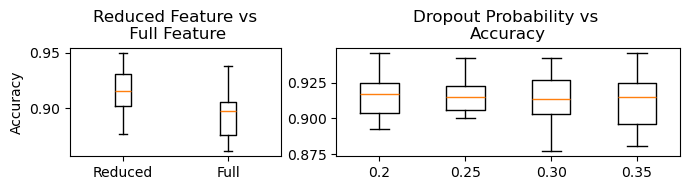

In [40]:
import matplotlib.pyplot as plt

# Create the layout with subplot_mosaic
layout = [["A", "A", "B", "B", "B"]]
fig, axes = plt.subplot_mosaic(layout, figsize=(7, 2))

# Access the axes
ax1 = axes["A"]  # Left subplot (1/3 of the width)
ax1.boxplot([reduced_feature_acc, full_feature_acc], labels=['Reduced', 'Full'])
ax1.set_title('Reduced Feature vs\n Full Feature')
ax1.set_ylabel('Accuracy')

ax2 = axes["B"]  # Right subplot (2/3 of the width)
ax2.set_title('Dropout Probability vs \nAccuracy')
ax2.boxplot([drop_20, drop_25, drop_30, drop_35], labels=['0.2', '0.25', '0.30', '0.35'])

plt.tight_layout()
plt.show()

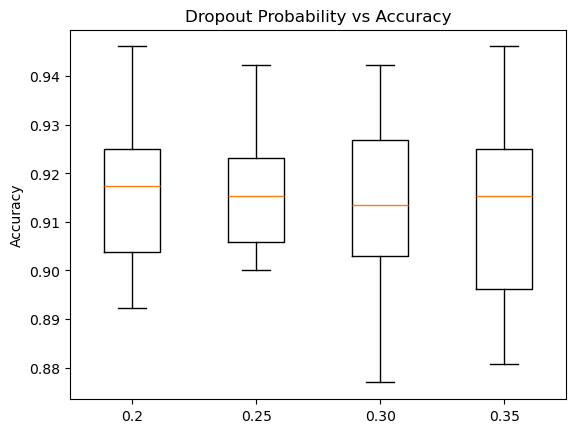

In [ ]:
batch_size = 10
dp_in_sample = int(df_train.shape[0] /10)

n_partitions = 10
partitions = np.array_split(df_train, n_partitions)
num_features = None
for drop_out in [.2, .25, .3, .35]:
    all_acc = []
    for i in range(10):
        #i_train_df = df_train.sample(n=df_train.shape[0], replace=True)
        #i_valid_df = df_valid.sample(n=df_valid.shape[0], replace=True)
        # partition dataset
        i_train_df = pd.concat([partitions[j] for j in range(len(partitions)) if j != i],axis=0)
        i_valid_df = partitions[i]

        y_train = i_train_df["Target"]
        x_train = i_train_df.drop(["Target"], axis=1)
        num_featurs = x_train.shape[0]

        y_valid = i_valid_df["Target"]
        x_valid = i_valid_df.drop(["Target"], axis=1)

        train_dl = DataLoader(DropoutDS(x_train, y_train), batch_size=batch_size, shuffle=True)
        valid_dl = DataLoader(DropoutDS(x_valid, y_valid), batch_size=batch_size, shuffle=True)
        acc = train_model(train_dl, valid_dl, i, dropout=drop_out)
        all_acc.append(acc)
    all_acc = np.array(all_acc)
    np.save(f'mlp_ensemble/feature_acc/{x_train.shape[1]}_{drop_out}.npy',all_acc)